In [1]:
import numpy as np
from scipy.special import genlaguerre, factorial
import matplotlib.pyplot as plt
from functools import cache
%load_ext line_profiler

from matplotlib import cm
from matplotlib.colors import Normalize


In [2]:
hbar = 1
def wig_mn(m, n, x, p):
    """Wigner function of |m><n| state
    """
    if n > m:
        return wig_mn(n, m, x, -p)
        #m, n = n, m
        #p = -p

    x /= np.sqrt(hbar)
    p /= np.sqrt(hbar)
    
    return (-1)**n * (x-p*1j)**(m-n) * 1/(np.pi) * np.exp(-x*x - p*p) * \
            np.sqrt(2**(m-n) * factorial(n) / factorial(m)) * \
            genlaguerre(n, m-n)(2*x*x + 2*p*p)

def rho_mn(m,n, W, x, p):
    X,P=np.meshgrid(x,p)
    Wmn = wig_mn(m,n,X,P)
    dx = np.diff(x)[0]
    dp = np.diff(p)[0]
    
    return np.pi*2*np.sum(Wmn*W)*dx*dp


In [3]:
x = np.linspace(-5,5,1000)
%lprun -f wig_mn wig_mn(100,200,x,x)

Timer unit: 1e-09 s

Total time: 0.002813 s
File: /var/folders/m2/hpgw6ky53rbgdd595zcgg_bm0000gp/T/ipykernel_69866/2316761831.py
Function: wig_mn at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def wig_mn(m, n, x, p):
     3                                               """Wigner function of |m><n| state
     4                                               """
     5         2       2000.0   1000.0      0.1      if n > m:
     6         1      10000.0  10000.0      0.4          return wig_mn(n, m, x, -p)
     7                                                   #m, n = n, m
     8                                                   #p = -p
     9                                           
    10         1      10000.0  10000.0      0.4      x /= np.sqrt(hbar)
    11         1       4000.0   4000.0      0.1      p /= np.sqrt(hbar)
    12                                               
    13         3    1201000.0 40

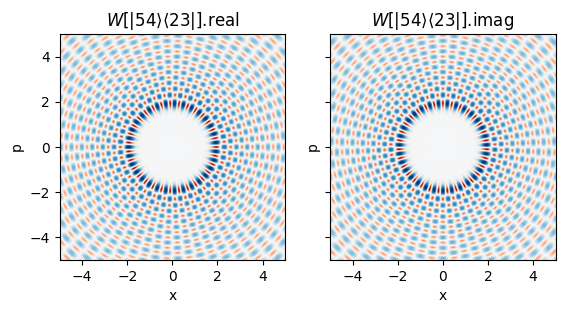

In [4]:
m = 54
n = 23

x = np.linspace(-5,5,1000)
X, P = np.meshgrid(x,x)
W = wig_mn(m,n,X,P)

fig, axes = plt.subplots(1,2, sharex = True, sharey=True)
axes[0].contourf(x,x,W.real, 100,cmap = cm.RdBu)
axes[0].set_title(rf'$W\left[|{m}\rangle\langle{n}|\right]$.real')
axes[1].contourf(x,x,W.imag,100,cmap = cm.RdBu)
axes[1].set_title(rf'$W\left[|{m}\rangle\langle{n}|\right]$.imag')
for ax in axes: 
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('p')

## Pick a random rho and calculate the Wigner

In [11]:
x = np.linspace(-5,5,100)
X, P = np.meshgrid(x,x)
#cns = np.array([0,1])

np.random.seed = 10
rho = np.random.rand(10,10)

W = np.zeros((len(x),len(x)),dtype = complex)

for i in range(10):
    for j in range(10):
        if rho[i,j] != 0: 
            W += rho[i,j]*wig_mn(i,j,X,P)
        else:
            print('Zero')

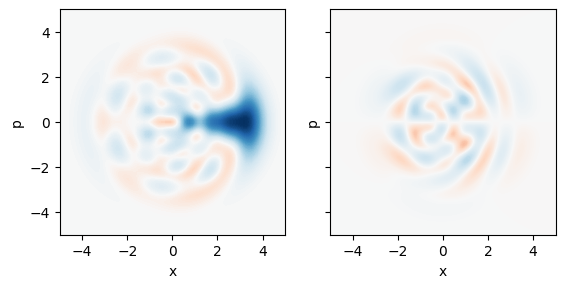

In [12]:
fig, axes = plt.subplots(1,2, sharex = True, sharey=True)

scale = np.max(W.real)
nrm = Normalize(-scale, scale)

axes[0].contourf(x,x,W.real, 100, cmap = cm.RdBu, norm =nrm)
axes[1].contourf(x,x,W.imag, 100, cmap = cm.RdBu, norm = nrm)
for ax in axes: 
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('p')

In [37]:
%%timeit
W = np.zeros((len(x),len(x)),dtype = complex)

for i in range(10):
    for j in range(10):
        if rho[i,j] != 0: 
            W += rho[i,j]*wig_mn(i,j,X,P)

31.1 ms ± 5.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Obtain rho from Wigner

In [38]:
rho = np.random.rand(10,10)

W = np.zeros((len(x),len(x)),dtype = complex)

for i in range(10):
    for j in range(10):
        if rho[i,j] != 0: 
            W += rho[i,j]*wig_mn(i,j,X,P)

rho_new = np.zeros((nmax,nmax),dtype=complex)

for i in range(10):
    for j in range(10):
        rho_new[j,i] = rho_mn(i,j,W,x,x)


In [39]:
np.allclose(np.round(rho,3),np.round(rho_new.real,3))

True

In [42]:
%%timeit
rho_new = np.zeros((nmax,nmax),dtype=complex)

for i in range(10):
    for j in range(10):
        rho_new[j,i] = rho_mn(i,j,W,x,x)

31.5 ms ± 5.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
